## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
420
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|-12268.765203613644| -825.7982574517628| 2286.6759004873775|   2139.7|SSSBSSBB| 37.2275|-119.2206|       SNWD|0.08125103815927784|0.07298132861948865| 0.0372817453669047

In [38]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00044176| 37.2275|-119.2206|   2139.7|-12268.765203613644|
|USC00049633| 37.5833|-118.2333|   3800.9| -7369.575258182767|
|USC00044176| 37.2275|-119.2206|   2139.7| -10331.75893637608|
|USC00049632|    37.5|-118.1833|   3093.7| -9877.938960612995|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [52]:
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df=sqlContext.read.parquet(filename)
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT DISTINCT latitude, longitude,station FROM weather\n\tWHERE measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s' OR measurement='%s' and station='%s'"%('PRCP','US1CACV0004','PRCP','US1CAIN0002','PRCP','US1CAMA0001','PRCP','US1CAMA0002','PRCP','US1CAMA0003','PRCP','US1CAMN0001','PRCP','US1CAMP0001','PRCP','US1CAMP0002','PRCP','US1CAMP0003','PRCP','US1CAMP0004')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show()

SELECT DISTINCT latitude, longitude,station FROM weather
	WHERE measurement='PRCP' and station='US1CACV0004' OR measurement='PRCP' and station='US1CAIN0002' OR measurement='PRCP' and station='US1CAMA0001' OR measurement='PRCP' and station='US1CAMA0002' OR measurement='PRCP' and station='US1CAMA0003' OR measurement='PRCP' and station='US1CAMN0001' OR measurement='PRCP' and station='US1CAMP0001' OR measurement='PRCP' and station='US1CAMP0002' OR measurement='PRCP' and station='US1CAMP0003' OR measurement='PRCP' and station='US1CAMP0004'
10 rows
+--------+---------+-----------+
|latitude|longitude|    station|
+--------+---------+-----------+
| 37.3227|-118.5404|US1CAIN0002|
| 37.1241| -119.761|US1CAMA0003|
| 38.1652|-120.4124|US1CACV0004|
| 37.4415|-119.6316|US1CAMA0001|
| 38.0337|-119.1697|US1CAMN0001|
| 37.2717| -119.802|US1CAMA0002|
| 37.4613|-119.7417|US1CAMP0002|
| 37.6354|-120.3273|US1CAMP0003|
| 37.4152|-120.0998|US1CAMP0004|
| 37.5396|-119.9876|US1CAMP0001|
+--------+---------+--

In [55]:
#df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df1.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(2)
pdf

latitude  longitude      station
2   38.1652  -120.4124  US1CACV0004
0   37.3227  -118.5404  US1CAIN0002
3   37.4415  -119.6316  US1CAMA0001
5   37.2717  -119.8020  US1CAMA0002
1   37.1241  -119.7610  US1CAMA0003
4   38.0337  -119.1697  US1CAMN0001
9   37.5396  -119.9876  US1CAMP0001
6   37.4613  -119.7417  US1CAMP0002
7   37.6354  -120.3273  US1CAMP0003
8   37.4152  -120.0998  US1CAMP0004

In [56]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
#_avg='count(%s)'%'station'
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

KeyError: 'avg(coeff_1)'

## Map

In [57]:
minLat = df1.rdd.map(lambda row : row['latitude']).min()
maxLat = df1.rdd.map(lambda row : row['latitude']).max()
minLong = df1.rdd.map(lambda row : row['longitude']).min()
maxLong = df1.rdd.map(lambda row : row['longitude']).max()
print minLat, maxLat, minLong, maxLong

37.1241 38.1652 -120.4124 -118.5404


In [58]:
pdf

latitude  longitude      station
2   38.1652  -120.4124  US1CACV0004
0   37.3227  -118.5404  US1CAIN0002
3   37.4415  -119.6316  US1CAMA0001
5   37.2717  -119.8020  US1CAMA0002
1   37.1241  -119.7610  US1CAMA0003
4   38.0337  -119.1697  US1CAMN0001
9   37.5396  -119.9876  US1CAMP0001
6   37.4613  -119.7417  US1CAMP0002
7   37.6354  -120.3273  US1CAMP0003
8   37.4152  -120.0998  US1CAMP0004

In [59]:
#min_lat,max_lat,min_long,max_long = box = (42.1103, 42.6167, -72.6, -70.8)
min_lat,max_lat,min_long,max_long = box = (37.0833, 38.2, -120.3667, -115.5833)

In [65]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

#r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
#m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    #_count=row['count(station)']
    #_coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    #*np.sqrt(_count+0.0)
    c = Circle(location=(_lat,_long), radius=int(3000), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            #fill_color=get_color(_coef))
            #fill_color=get_color(_count)
              )
    circles.append(c)
    m.add_layer(c)
m    

In [ ]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
            #fill_color=get_color(_count))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

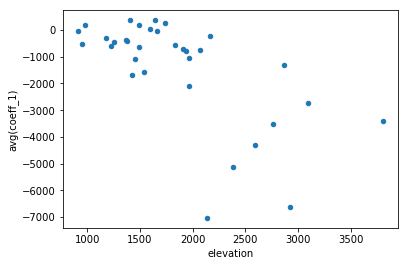

In [15]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [16]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']